# Intro Task, Object Localization

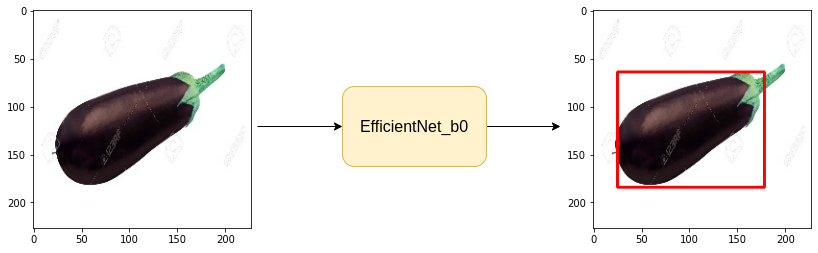

In [3]:
# # install libraries/packages/modules
#
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install timm
# !pip install --upgrade opencv-contrib-python

In [4]:
# # Download Dataset
#
# !git clone https://github.com/parth1620/object-localization-dataset.git

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path

# Configurations

In [2]:
CSV_FILE = './object-localization-dataset/train.csv'
DATA_DIR = Path('./object-localization-dataset/')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [3]:
df = pd.read_csv(CSV_FILE)
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


# Understand the dataset

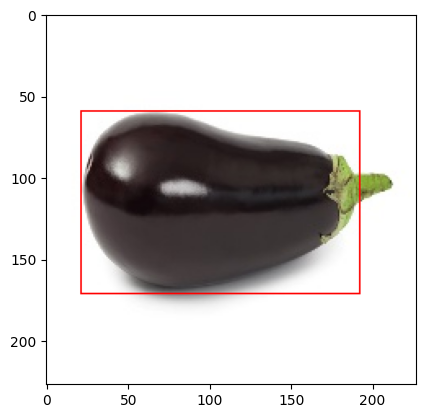

In [4]:
row = df.iloc[184]
img = cv2.imread(str(DATA_DIR/row['img_path']))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row['xmin'], row['ymin'])
pt2 = (row['xmax'], row['ymax'])
bbox_img = cv2.rectangle(img.copy(), pt1, pt2, color=(255, 0, 0))
plt.imshow(bbox_img)
plt.show()

In [5]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [6]:
import albumentations as A

In [7]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(p=0.5),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [10]:
class ObjLocDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentations = None):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        xmin, ymin = row['xmin'], row['ymin']
        xmax, ymax = row['xmax'], row['ymax']
        bbox = [[xmin, ymin, xmax, ymax]]

        img_path = DATA_DIR/row['img_path']
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            data = self.augmentations(image = img, bboxes=bbox, class_labels=[None])
            img = data['image']
            bbox = data['bboxes'][0]

        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0 # (h, w, c) -> (c, h, w)
        bbox = torch.Tensor(bbox)

        return img, bbox

In [11]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [12]:
print("Total examples in the trainset:", len(trainset))
print("Total examples in the validset:", len(validset))

Total examples in the trainset: 148
Total examples in the validset: 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


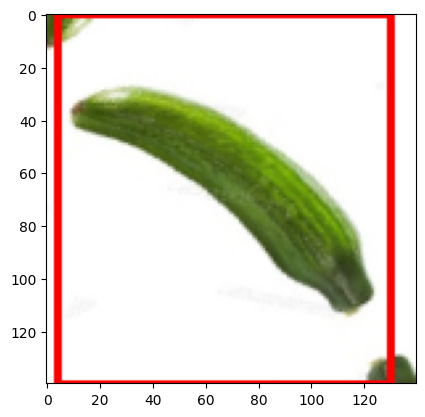

In [14]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)
plt.show()

# Load dataset into batches

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [17]:
for images, bboxes in trainloader:
    break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [18]:
from torch import nn
import timm

In [41]:
class ObjLocModel(nn.Module):

    def __init__(self):
        super(ObjLocModel, self).__init__()

        self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)

    def forward(self, images, gt_bboxes=None):
        logits_bboxes = self.backbone(images)

        if gt_bboxes != None:
            loss = nn.MSELoss()(logits_bboxes, gt_bboxes)
            return logits_bboxes, loss

        return logits_bboxes

In [42]:
model = ObjLocModel()
model.to(DEVICE);

# Create Train and Eval Function

In [43]:
def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train() # Dropout ON

    for data in tqdm(dataloader):
        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

        bboxes, loss = model(images, gt_bboxes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [44]:
def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval() # Dropout ON

    with torch.no_grad():
        for data in tqdm(dataloader):
            images, gt_bboxes = data
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images, gt_bboxes)
            total_loss += loss.item()

        return total_loss / len(dataloader)

# Training Loop

In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("WEIGHT ARE SAVED!")
        best_valid_loss = valid_loss

    print(f"Epoch: {i+1} train loss : {train_loss} valid loss : {valid_loss}")

# Inference

In [49]:
import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


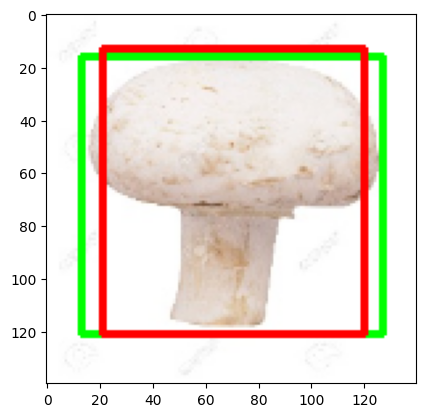

In [54]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    image, gt_bbox = validset[1]
    image = image.unsqueeze(0).to(DEVICE)
    out_bbox = model(image)

    utils.compare_plots(image, gt_bbox, out_bbox)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya